## Benchmarking scVI MLflow Model with czbenchmarks

This notebook demonstrates how to:

- Package a pre-trained scVI model using MLflow
- Use czbenchmarks datasets for evaluation
- Run inference through the MLflow model interface
- Evaluate the model embeddings using czbenchmarks tasks
- Compare results with PCA baselines



### Setup and Model Packaging

In this section, we'll clone the scvi_mlflow_pkg repository, set up the environment, and package the scVI model as an MLflow artifact.

In [ ]:
# Package the VCP mlflow model to run within this notebook.
# -------------------------------------------------------------------
# This script must be run before executing any benchmarking steps below.
# It will:
#   - Package the VCP model as an MLflow artifact
#   - Save the model path to 'mlflow_model_path.txt'
#   - Ensure the model is ready for downstream czbenchmarks evaluation
# -------------------------------------------------------------------
!./package_vcp_model.sh

#### Optional: Environment Setup for Notebook

To ensure all dependencies are available, you can create a dedicated Python environment and install all required packages. 


In [2]:
# # ---------------------------------------------------------------
# # Optional: Create an isolated virtual environment
# # ---------------------------------------------------------------
# # This step is only needed if you want to ensure full isolation from your base Python environment.
# # Run each command below one at a time (remove the leading '#' to execute).
# # After running, restart your Jupyter kernel and select "Python (.venv_scvi)" as your kernel.

# # 1. Create a new virtual environment (run once)
# !python3 -m venv .venv_scvi

# # 2. Upgrade pip and install required packages
# !.venv_scvi/bin/python -m pip install --upgrade pip
# !.venv_scvi/bin/python -m pip install ipykernel numpy pandas scvi-tools tabulate matplotlib seaborn czbenchmarks anndata mlflow

# # 3. Register the new environment as a Jupyter kernel
# !.venv_scvi/bin/python -m ipykernel install --user --name venv_scvi --display-name "Python (.venv_scvi)"

# print("Virtual environment setup instructions provided. To use, uncomment and run each step above, then restart the kernel and select 'Python (.venv_scvi)'.")

#### Setup and Imports

In [ ]:
import os
import functools
import pandas as pd
import numpy as np

from czbenchmarks.datasets import load_dataset
from czbenchmarks.datasets.single_cell_labeled import SingleCellLabeledDataset

#### Load MLflow Model Path

In [ ]:
# Load MLflow model path
MLFLOW_MODEL_PATH = None
with open("mlflow_model_path.txt", "r") as f:
    MLFLOW_MODEL_PATH = f.read().strip()
print(f"MLflow model path: {MLFLOW_MODEL_PATH}")

### Dataset Preparation with czbenchmarks

Now we'll load a dataset from czbenchmarks and prepare it for inference with our MLflow-packaged scVI model. We need to ensure the dataset has the required observation columns (batch_keys) and save it in the correct format.

In [15]:
# Load czbenchmarks dataset
dataset: SingleCellLabeledDataset = load_dataset("tsv2_prostate")
dataset.adata
dataset.labels

TSP25_Prostate_NA_10X_1_1_AAACCCAAGTGGTTAA                       endothelial cell
TSP25_Prostate_NA_10X_1_1_AAACCCACATGCACTA    luminal cell of prostate epithelium
TSP25_Prostate_NA_10X_1_1_AAACGAAGTTCTGACA                       endothelial cell
TSP25_Prostate_NA_10X_1_1_AAACGCTTCTACCCAC                            erythrocyte
TSP25_Prostate_NA_10X_1_1_AAAGAACCAGTTGTCA                     smooth muscle cell
                                                             ...                 
TSP25_Prostate_NA_10X_1_2_TTTATGCTCTTGGTCC                             fibroblast
TSP25_Prostate_NA_10X_1_2_TTTCACAAGATCGGTG      basal cell of prostate epithelium
TSP25_Prostate_NA_10X_1_2_TTTCACAGTGCCTTCT                             fibroblast
TSP25_Prostate_NA_10X_1_2_TTTCATGCAATAGTAG        CD8-positive, alpha-beta T cell
TSP25_Prostate_NA_10X_1_2_TTTCCTCAGGTGATCG                             fibroblast
Name: cell_type, Length: 2044, dtype: category
Categories (14, object): ['fibroblast', 'T cell', '

#### Prepare dataset for model input

In [16]:
adata = dataset.adata.copy()

# Ensure required batch_keys exist
expected_batch_keys = ["dataset_id", "assay", "suspension_type", "donor_id"]
for key in expected_batch_keys:
    if key not in adata.obs.columns:
        adata.obs[key] = f"default_{key}"

# Create batch identifier
adata.obs["batch"] = functools.reduce(
    lambda a, b: a + b, [adata.obs[c].astype(str) + "_" for c in expected_batch_keys]
).str.rstrip("_")

# Save prepared dataset
prepared_data_path = "prepared_dataset.h5ad"
adata.write_h5ad(prepared_data_path)

# Store for later use
DATASET_PATH = os.path.abspath(prepared_data_path)
BATCH_KEYS_STR = ",".join(expected_batch_keys)
ORIGINAL_LABELS = dataset.labels.copy()
ORIGINAL_ADATA_FOR_BASELINE = dataset.adata.copy()

### MLflow Model Inference

In this section, we'll prepare the input for our MLflow-packaged scVI model, run inference, and extract the embeddings. The MLflow model expects input in a specific JSON format with the dataset path and parameters.

In [17]:
import mlflow

# Prepare input DataFrame for MLflow model
input_df = pd.DataFrame({"input_uri": [DATASET_PATH]})
print(DATASET_PATH)
print(f"MLflow model path: {MLFLOW_MODEL_PATH}")
# Run MLflow model prediction
loaded_model = mlflow.pyfunc.load_model(MLFLOW_MODEL_PATH)
predictions = loaded_model.predict(
    input_df,
    params={"organism": "human", "return_dist": True, "batch_keys": BATCH_KEYS_STR},
)

# Convert to numpy array if needed
model_embeddings = (
    predictions.values if hasattr(predictions, "values") else np.array(predictions)
)

/Users/sgupta/cz-benchmarks/examples/prepared_dataset.h5ad
MLflow model path: /Users/sgupta/cz-benchmarks/examples/vcp-model-pkg-client-tools/examples/mlflow_pkgs/scvi_mlflow_pkg/mlflow_model_artifact


2025/07/30 15:22:46 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - anndata (current: 0.11.4, required: anndata==0.10.8)
 - databricks-sdk (current: 0.60.0, required: databricks-sdk==0.59.0)
 - flax (current: 0.10.7, required: flax==0.10.4)
 - gitpython (current: 3.1.45, required: gitpython==3.1.44)
 - greenlet (current: uninstalled, required: greenlet==3.2.3)
 - jax (current: 0.6.2, required: jax==0.4.33)
 - jaxlib (current: 0.6.2, required: jaxlib==0.4.33)
 - numpy (current: 2.2.6, required: numpy==1.26.4)
 - opentelemetry-api (current: 1.36.0, required: opentelemetry-api==1.35.0)
 - opentelemetry-sdk (current: 1.36.0, required: opentelemetry-sdk==1.35.0)
 - opentelemetry-semantic-conventions (current: 0.57b0, required: opentelemetry-semantic-conventions==0.56b0)
 - orbax-checkpoint (current: 0.11.19, required: orbax-checkpoint==0.6.4)
 - pandas (current: 2.3.1, required: pandas==2.2.3)
 

INFO     File                                                                                                      
         /Users/sgupta/cz-benchmarks/examples/vcp-model-pkg-client-tools/examples/mlflow_pkgs/scvi_mlflow_pkg/mlflo
         w_model_artifact/artifacts/homo_sapiens/model.pt already downloaded                                       
INFO     Found 44.05% reference vars in query data.                                                                


/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/scvi/model/base/_archesmixin.py:299: UserWarning: Query data contains less than 80% of reference var names. This may result in poor performance.
  return _pad_and_sort_query_anndata(adata, var_names, inplace)


INFO     File                                                                                                      
         /Users/sgupta/cz-benchmarks/examples/vcp-model-pkg-client-tools/examples/mlflow_pkgs/scvi_mlflow_pkg/mlflo
         w_model_artifact/artifacts/homo_sapiens/model.pt already downloaded                                       


/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/scvi/model/base/_archesmixin.py:105: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  _, _, device = parse_device_args(


### czbenchmarks Task Evaluation

Finally, we'll use the embeddings from our MLflow model to run czbenchmarks tasks including clustering, embedding quality assessment, and metadata label prediction. We'll compare the results with PCA baselines and generate visualizations.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from czbenchmarks.tasks import (
    ClusteringTask,
    EmbeddingTask,
    MetadataLabelPredictionTask,
)
from czbenchmarks.tasks.clustering import ClusteringTaskInput
from czbenchmarks.tasks.embedding import EmbeddingTaskInput
from czbenchmarks.tasks.label_prediction import MetadataLabelPredictionTaskInput

# Prepare data for tasks
expression_data = ORIGINAL_ADATA_FOR_BASELINE.X
labels = ORIGINAL_LABELS
obs_data = ORIGINAL_ADATA_FOR_BASELINE.obs
all_results = {}

##### Task 1: Clustering Performance

In [20]:
# Clustering Task
clustering_task = ClusteringTask()
clustering_task_input = ClusteringTaskInput(obs=obs_data, input_labels=labels)

clustering_results_model = clustering_task.run(
    cell_representation=model_embeddings,
    task_input=clustering_task_input,
)
clustering_baseline_embedding = clustering_task.compute_baseline(expression_data)
clustering_results_baseline = clustering_task.run(
    cell_representation=clustering_baseline_embedding,
    task_input=clustering_task_input,
)

all_results["clustering"] = {
    "model": [r.model_dump() for r in clustering_results_model],
    "baseline": [r.model_dump() for r in clustering_results_baseline],
}

print("Clustering results:")
for result in all_results["clustering"]["model"]:
    print(result)

Clustering results:
{'metric_type': <MetricType.ADJUSTED_RAND_INDEX: 'adjusted_rand_index'>, 'value': 0.7282581538681618, 'params': {}}
{'metric_type': <MetricType.NORMALIZED_MUTUAL_INFO: 'normalized_mutual_info'>, 'value': 0.8693815660627174, 'params': {}}


##### Task 2: Embedding Quality


In [21]:
# Embedding Quality Task
embedding_task = EmbeddingTask()
embedding_task_input = EmbeddingTaskInput(input_labels=labels)

embedding_results_model = embedding_task.run(model_embeddings, embedding_task_input)
embedding_baseline_embedding = embedding_task.compute_baseline(expression_data)
embedding_results_baseline = embedding_task.run(
    embedding_baseline_embedding, embedding_task_input
)

all_results["embedding"] = {
    "model": [r.model_dump() for r in embedding_results_model],
    "baseline": [r.model_dump() for r in embedding_results_baseline],
}


print("Embedding results:")
for result in all_results["embedding"]["model"]:
    print(result)

INFO:2025-07-30 15:26:48,421:jax._src.xla_bridge:752: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/sgupta/.pyenv/versions/3.10.16/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/sgupta/.pyenv/versions/3.10.16/lib/libtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/sgupta/.pyenv/versions/3.10.16/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/sgupta/.pyenv/versions/3

Embedding results:
{'metric_type': <MetricType.SILHOUETTE_SCORE: 'silhouette_score'>, 'value': 0.627913236618042, 'params': {}}


##### Task 3: Metadata Label Prediction


In [22]:
# Metadata Label Prediction Task
prediction_task = MetadataLabelPredictionTask()
prediction_task_input = MetadataLabelPredictionTaskInput(labels=labels)

prediction_results_model = prediction_task.run(model_embeddings, prediction_task_input)
prediction_baseline_embedding = prediction_task.compute_baseline(expression_data)
prediction_results_baseline = prediction_task.run(
    prediction_baseline_embedding, prediction_task_input
)

all_results["prediction"] = {
    "model": [r.model_dump() for r in prediction_results_model],
    "baseline": [r.model_dump() for r in prediction_results_baseline],
}

print("Prediction results:")
for result in all_results["prediction"]["model"]:
    print(result)

INFO:czbenchmarks.tasks.label_prediction:Starting prediction task for labels
INFO:czbenchmarks.tasks.label_prediction:Initial data shape: (2044, 50), labels shape: (2044,)
INFO:czbenchmarks.tasks.utils:Label composition (cell_type):
INFO:czbenchmarks.tasks.utils:Total classes before filtering: 14
INFO:czbenchmarks.tasks.utils:Total classes after filtering (min_class_size=10): 13
INFO:czbenchmarks.tasks.label_prediction:After filtering: (2043, 50) samples remaining
INFO:czbenchmarks.tasks.label_prediction:Found 13 classes, using macro averaging for metrics
INFO:czbenchmarks.tasks.label_prediction:Using 5-fold cross validation with random_seed 42
INFO:czbenchmarks.tasks.label_prediction:Created classifiers: ['lr', 'knn', 'rf']
INFO:czbenchmarks.tasks.label_prediction:Running cross-validation for lr...
/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 i

Prediction results:
{'metric_type': <MetricType.MEAN_FOLD_ACCURACY: 'mean_fold_accuracy'>, 'value': 0.958237051951995, 'params': {'classifier': 'MEAN(knn,lr,rf)'}}
{'metric_type': <MetricType.MEAN_FOLD_F1_SCORE: 'mean_fold_f1'>, 'value': 0.905656180500994, 'params': {'classifier': 'MEAN(knn,lr,rf)'}}
{'metric_type': <MetricType.MEAN_FOLD_PRECISION: 'mean_fold_precision'>, 'value': 0.9146813924111253, 'params': {'classifier': 'MEAN(knn,lr,rf)'}}
{'metric_type': <MetricType.MEAN_FOLD_RECALL: 'mean_fold_recall'>, 'value': 0.905266056603905, 'params': {'classifier': 'MEAN(knn,lr,rf)'}}
{'metric_type': <MetricType.MEAN_FOLD_AUROC: 'mean_fold_auroc'>, 'value': 0.9923419466419218, 'params': {'classifier': 'MEAN(knn,lr,rf)'}}
{'metric_type': <MetricType.MEAN_FOLD_ACCURACY: 'mean_fold_accuracy'>, 'value': 0.9647586173833836, 'params': {'classifier': 'lr'}}
{'metric_type': <MetricType.MEAN_FOLD_F1_SCORE: 'mean_fold_f1'>, 'value': 0.9184559659423588, 'params': {'classifier': 'lr'}}
{'metric_type'

### Results Visualization

Visualize and compare the results for each task.

##### Visualization: Clustering Performance

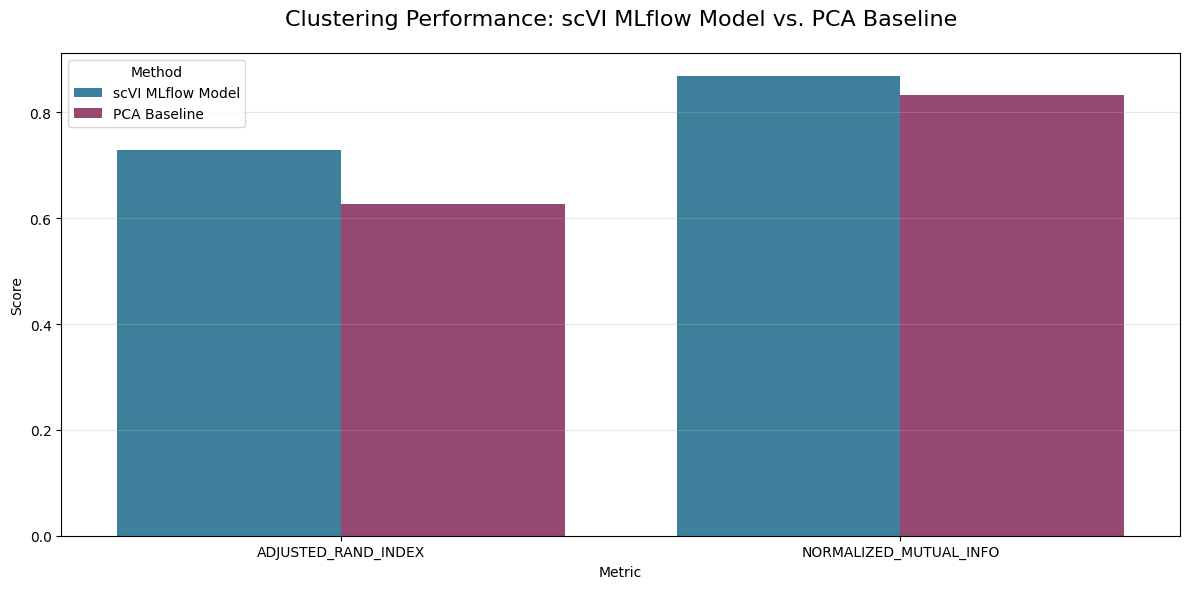

In [23]:
sns.set_theme(style="whitegrid")
plt.style.use("default")

df_clustering_model = pd.DataFrame(all_results["clustering"]["model"])
df_clustering_baseline = pd.DataFrame(all_results["clustering"]["baseline"])
df_clustering_model["source"] = "scVI MLflow Model"
df_clustering_baseline["source"] = "PCA Baseline"
df_clustering = pd.concat([df_clustering_model, df_clustering_baseline])
df_clustering["metric_name"] = df_clustering["metric_type"].apply(lambda x: x.name)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_clustering,
    x="metric_name",
    y="value",
    hue="source",
    palette=["#2E86AB", "#A23B72"],
)
plt.title(
    "Clustering Performance: scVI MLflow Model vs. PCA Baseline", fontsize=16, pad=20
)
plt.ylabel("Score")
plt.xlabel("Metric")
plt.legend(title="Method", frameon=True)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

##### Visualization: Embedding Quality

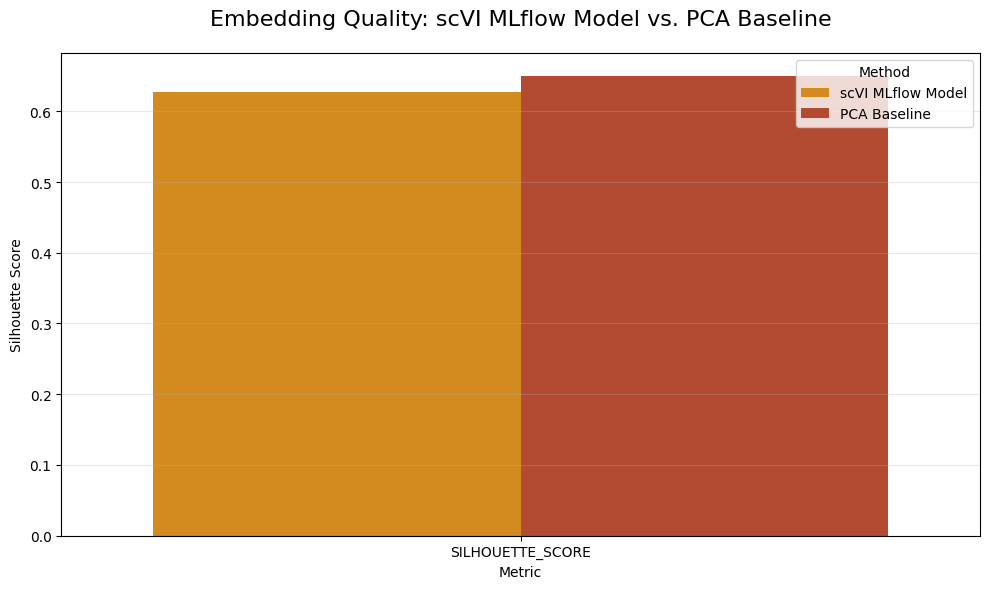

In [24]:
df_embedding_model = pd.DataFrame(all_results["embedding"]["model"])
df_embedding_baseline = pd.DataFrame(all_results["embedding"]["baseline"])
df_embedding_model["source"] = "scVI MLflow Model"
df_embedding_baseline["source"] = "PCA Baseline"
df_embedding = pd.concat([df_embedding_model, df_embedding_baseline])
df_embedding["metric_name"] = df_embedding["metric_type"].apply(lambda x: x.name)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_embedding,
    x="metric_name",
    y="value",
    hue="source",
    palette=["#F18F01", "#C73E1D"],
)
plt.title("Embedding Quality: scVI MLflow Model vs. PCA Baseline", fontsize=16, pad=20)
plt.ylabel("Silhouette Score")
plt.xlabel("Metric")
plt.legend(title="Method", frameon=True)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

##### Visualization: Label Prediction

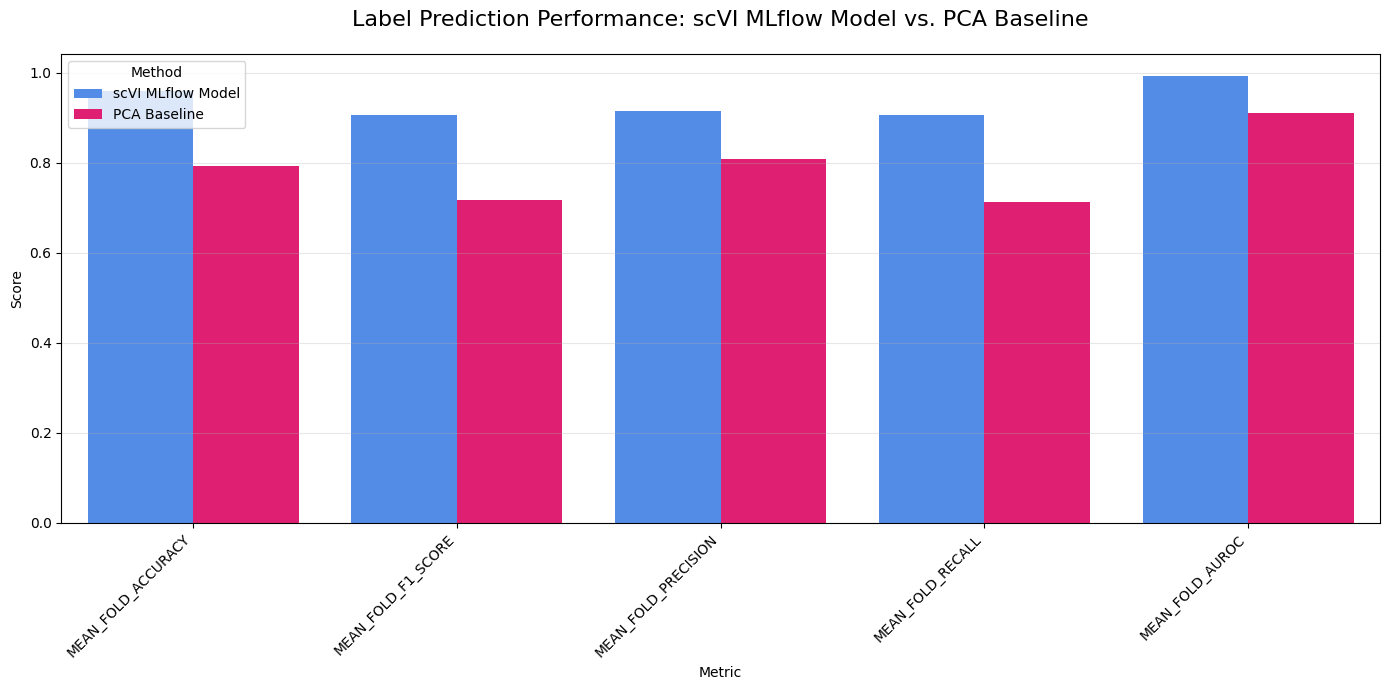

In [25]:
df_pred_model = pd.DataFrame(all_results["prediction"]["model"])
df_pred_baseline = pd.DataFrame(all_results["prediction"]["baseline"])
df_pred_model["source"] = "scVI MLflow Model"
df_pred_baseline["source"] = "PCA Baseline"
df_pred = pd.concat([df_pred_model, df_pred_baseline])
df_pred["metric_name"] = df_pred["metric_type"].apply(lambda x: x.name)
df_pred["classifier"] = df_pred["params"].apply(
    lambda p: p.get("classifier", "Overall")
)

# Filter for mean metrics for cleaner visualization
df_pred_mean = df_pred[df_pred["classifier"].str.contains("MEAN", na=False)]

plt.figure(figsize=(14, 7))
sns.barplot(
    data=df_pred_mean,
    x="metric_name",
    y="value",
    hue="source",
    palette=["#3A86FF", "#FF006E"],
)
plt.title(
    "Label Prediction Performance: scVI MLflow Model vs. PCA Baseline",
    fontsize=16,
    pad=20,
)
plt.ylabel("Score")
plt.xlabel("Metric")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Method", frameon=True)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()